# CS354 Project Draft

Kaggle Data (Tweets): https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

Download data as a zip file, unzip the data in the VM, and then use the data from there. DO NOT DOWNLOAD FULL FILE TO YOUR LAPTOP!

Information about cleaning Twitter dataset: https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis

NLP cleaning resource: https://gauravtanwar1.medium.com/nlp-a-comprehensive-guide-to-text-cleaning-and-preprocessing-63f364febfc5

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("project").getOrCreate()

While we cannot use the Twitter API, we are using a toy dataset from Kaggle containing Tweets in order to get familiar with this type of data and what a dataset may look like for BlueSky. We will ensure that the BlueSky and Twitter data is in the same overall format, so that any models we create with the Twitter data can then be applied to real-time BlueSky posts. From what we understand, the overall process should be the same no matter the platform (Twitter vs BlueSky), and if our models can be versatile to different sites, we feel as though it would put us in a good place.

In [2]:
df = spark.read.csv("project_training.csv", header=False, inferSchema=True)

In [3]:
df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [4]:
df = df.withColumnRenamed("_c0", "polarity") # polarity of the tweet, 0, 2, 4 (negative, neutral, positive)
df = df.withColumnRenamed("_c1", "tweet_id") # id of the tweet
df = df.withColumnRenamed("_c2", "datetime") # time and date of the tweet
df = df.withColumnRenamed("_c3", "query") # idk what this is but it's there
df = df.withColumnRenamed("_c4", "username") # user's handle
df = df.withColumnRenamed("_c5", "contents") # content of the tweet

In [5]:
df.show()

+--------+----------+--------------------+--------+---------------+--------------------+
|polarity|  tweet_id|            datetime|   query|       username|            contents|
+--------+----------+--------------------+--------+---------------+--------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|       0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|       0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|       0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|       0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|       0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|       0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|       0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|       0|1467811795|

In [7]:
df.describe()

DataFrame[summary: string, polarity: string, tweet_id: string, datetime: string, query: string, username: string, contents: string]

In [6]:
df.printSchema()

root
 |-- polarity: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- datetime: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- contents: string (nullable = true)



## Initial Data Exploration (EDA) of Toy Dataset

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df_pd = df.toPandas()

In [18]:
df_pd.head()

,polarity,tweet_id,datetime,query,username,contents
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [19]:
df_pd.describe()

,polarity,tweet_id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [20]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int32 
 1   tweet_id  1600000 non-null  int64 
 2   datetime  1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   contents  1600000 non-null  object
dtypes: int32(1), int64(1), object(4)
memory usage: 67.1+ MB


<Axes: xlabel='polarity', ylabel='count'>

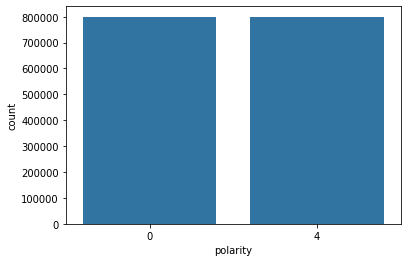

In [21]:
sns.countplot(x = 'polarity', data = df_pd)

Before cleaning, we can see that the data is very balanced when it comes to how many of each tweet there are in terms of polarity. While there are 3 different polarity labels shown on Kaggle, it would seem as though 2 has been disregarded, and all tweets were either given 0 or 4 (negative or positive) for polarity. 

In [22]:
# converting timestamp column to datetime-- removed time zone to match datetime format
df_pd['datetime_new'] = pd.to_datetime(df_pd['datetime'].str.replace(r'\s[PDT|PST|EST|GMT]{3,4}\s', ' ', regex=True), format='%a %b %d %H:%M:%S %Y')


In [23]:
df_pd.head()

,polarity,tweet_id,datetime,query,username,contents,datetime_new
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57


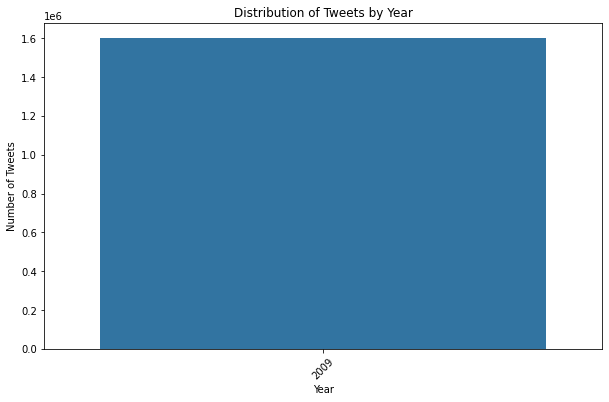

In [24]:
df_pd['year'] = df_pd['datetime_new'].dt.year

tweets_per_year = df_pd['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=tweets_per_year.index, y=tweets_per_year.values)
plt.title('Distribution of Tweets by Year')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

This allows us to see that all of the Tweets in the dataset are from 2009. We had originally thought that since the dataset was 8 years old, all of the Tweets would be from that same year. This is very helpful to know and provides context for future cleaning and modeling.

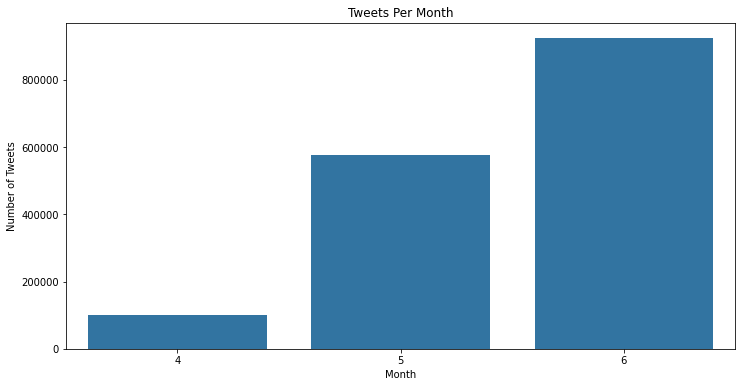

In [25]:
df_pd['month'] = df_pd['datetime_new'].dt.month

tweets_per_month = df_pd['month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=tweets_per_month.index, y=tweets_per_month.values)
plt.title('Tweets Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.show()

This bar plot allows us to see exactly what months in 2009 these Tweets originated and their frequencies. We had initially anticipated it would be from all of 2009, but it appears it is only the 2nd quarter of that year (April, May, and June). This is helpful to know and can also provide us with context as to what kind of illnesses or related keywords may be appearing in the Tweets. For instance, if this data came from the winter time, it would be unlikely that we'd see an influx of posts about spring allergies, a spring cold, or heat related issues.

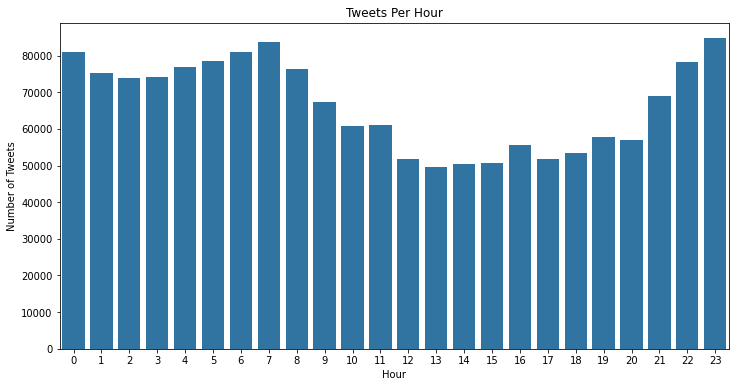

In [26]:
df_pd['hour'] = df_pd['datetime_new'].dt.hour

tweets_per_hour = df_pd['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=tweets_per_hour.index, y=tweets_per_hour.values)
plt.title('Tweets Per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.show()

From this bar plot, we can see that people posted more Tweets in the first 7 hours of the day and then later in the evening. This would make sense given that a typical work day often starts at 8am. It is helpful to see this information and provides insights that we can use later on, if needed.

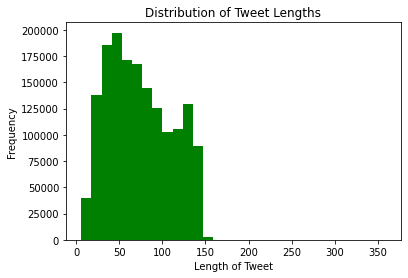

In [27]:
df_pd['tweet_length'] = df_pd['contents'].apply(len)
plt.hist(df_pd['tweet_length'], bins=30, color='green')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

While this plots looks a bit skewed, it actually is not. In 2009, the character limit on a Tweet was 140 characters, so in this plot we should not see a Tweet go past that 150 mark. This plot is helpful though, because it shows us that most individuals from April-June of 2009 were not utilizing their maximum amount of characters.

## Data Cleaning and Transformation (All Using PySpark DF)

In [10]:
df.columns

['polarity', 'tweet_id', 'datetime', 'query', 'username', 'contents']

In [11]:
# MAKE NEW COLUMN FOR DATETIME IN DATETIME FORMAT
import pyspark.sql.functions as f

df1 = df.withColumn( "datetime_clean",  
f.regexp_replace("datetime", r"^[A-Za-z]{3} ", "")  # Remove the day of the week 
) 

In [12]:
df1.show()

+--------+----------+--------------------+--------+---------------+--------------------+--------------------+
|polarity|  tweet_id|            datetime|   query|       username|            contents|      datetime_clean|
+--------+----------+--------------------+--------+---------------+--------------------+--------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|Apr 06 22:19:45 P...|
|       0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|Apr 06 22:19:49 P...|
|       0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|Apr 06 22:19:53 P...|
|       0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|Apr 06 22:19:57 P...|
|       0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|Apr 06 22:19:57 P...|
|       0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|Apr 06 22:20:00 P...|
|       0|

In [14]:
df2 = df1.withColumn( "datetime_column2",  
f.regexp_replace("datetime_clean", r"\s[A-Za-z]+$", "")  # Remove the timezone (e.g., "GMT") 
) 

In [15]:
df2.select('datetime_column2').head()

Row(datetime_column2='Apr 06 22:19:45 PDT 2009')

In [16]:
df2.show()

+--------+----------+--------------------+--------+---------------+--------------------+--------------------+--------------------+
|polarity|  tweet_id|            datetime|   query|       username|            contents|      datetime_clean|    datetime_column2|
+--------+----------+--------------------+--------+---------------+--------------------+--------------------+--------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|Apr 06 22:19:45 P...|Apr 06 22:19:45 P...|
|       0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|Apr 06 22:19:49 P...|Apr 06 22:19:49 P...|
|       0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|Apr 06 22:19:53 P...|Apr 06 22:19:53 P...|
|       0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|Apr 06 22:19:57 P...|Apr 06 22:19:57 P...|
|       0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass

In [17]:
df_final = df2.withColumn("datetime_final", f.to_timestamp(df2.datetime_column2, "MMM dd HH:mm:ss z yyyy"))

In [18]:
df_final.show()

+--------+----------+--------------------+--------+---------------+--------------------+--------------------+--------------------+-------------------+
|polarity|  tweet_id|            datetime|   query|       username|            contents|      datetime_clean|    datetime_column2|     datetime_final|
+--------+----------+--------------------+--------+---------------+--------------------+--------------------+--------------------+-------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|Apr 06 22:19:45 P...|Apr 06 22:19:45 P...|2009-04-07 05:19:45|
|       0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|Apr 06 22:19:49 P...|Apr 06 22:19:49 P...|2009-04-07 05:19:49|
|       0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|Apr 06 22:19:53 P...|Apr 06 22:19:53 P...|2009-04-07 05:19:53|
|       0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|Apr 06

In [19]:
df_final.select('datetime_final').show()

+-------------------+
|     datetime_final|
+-------------------+
|2009-04-07 05:19:45|
|2009-04-07 05:19:49|
|2009-04-07 05:19:53|
|2009-04-07 05:19:57|
|2009-04-07 05:19:57|
|2009-04-07 05:20:00|
|2009-04-07 05:20:03|
|2009-04-07 05:20:03|
|2009-04-07 05:20:05|
|2009-04-07 05:20:09|
|2009-04-07 05:20:16|
|2009-04-07 05:20:17|
|2009-04-07 05:20:19|
|2009-04-07 05:20:19|
|2009-04-07 05:20:20|
|2009-04-07 05:20:20|
|2009-04-07 05:20:22|
|2009-04-07 05:20:25|
|2009-04-07 05:20:31|
|2009-04-07 05:20:34|
+-------------------+
only showing top 20 rows



In [20]:
# DELETE QUERY POLARITY COLUMN, TWEETID COLUMN, AND OLD DATETIME COLUMN
df_finalized = df_final.drop("polarity", "query", "tweet_id", "datetime", "datetime_clean", "datetime_column2")

In [21]:
df_finalized.show()

+---------------+--------------------+-------------------+
|       username|            contents|     datetime_final|
+---------------+--------------------+-------------------+
|_TheSpecialOne_|@switchfoot http:...|2009-04-07 05:19:45|
|  scotthamilton|is upset that he ...|2009-04-07 05:19:49|
|       mattycus|@Kenichan I dived...|2009-04-07 05:19:53|
|        ElleCTF|my whole body fee...|2009-04-07 05:19:57|
|         Karoli|@nationwideclass ...|2009-04-07 05:19:57|
|       joy_wolf|@Kwesidei not the...|2009-04-07 05:20:00|
|        mybirch|         Need a hug |2009-04-07 05:20:03|
|           coZZ|@LOLTrish hey  lo...|2009-04-07 05:20:03|
|2Hood4Hollywood|@Tatiana_K nope t...|2009-04-07 05:20:05|
|        mimismo|@twittera que me ...|2009-04-07 05:20:09|
| erinx3leannexo|spring break in p...|2009-04-07 05:20:16|
|   pardonlauren|I just re-pierced...|2009-04-07 05:20:17|
|           TLeC|@caregiving I cou...|2009-04-07 05:20:19|
|robrobbierobert|@octolinz16 It it...|2009-04-07 05:20:1

#### Cleaning with NLP and Creating Pipeline

In [24]:
df_with_length = df_finalized.withColumn("length", length("contents"))

In [2]:
from pyspark.ml.feature import StopWordsRemover, RegexTokenizer, CountVectorizer, VectorAssembler
from pyspark.sql.functions import length
from pyspark.ml import Pipeline



regex_token = RegexTokenizer(
    inputCol = 'contents',
    outputCol = 'content_filtered',
    pattern = "\\W+",
    toLowercase = True
) # initially used Tokenizer, but changed to RegexTokenizer to account for additional characters and symbols

# Default Stop Words given by Spark StopWordsRemover
stopWords = StopWordsRemover.loadDefaultStopWords('english')

#customize stopwords
addStopWords = ['rt', 'via', 'amp', 'https', 'http', 'co', 'bsky', 'u', 'app', 'blueSky', 's', 'www', 'com','de'] #additional stop words common in posts that are not needed

stopWords = list(set(stopWords + addStopWords)) #combine both stopwords to one full list

stop_words_remover = StopWordsRemover(inputCol="content_filtered", outputCol="filtered_words", stopWords=stopWords)
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

vector_assembler = VectorAssembler(
    inputCols=['features', 'length'],
    outputCol='final_features'
)

full_pipeline = Pipeline(stages=[
    regex_token,
    stop_words_remover,
    count_vectorizer,
    vector_assembler
])

In [33]:
model = full_pipeline.fit(df_with_length)

clean_data = model.transform(df_with_length)

# Display the data
clean_data.show()

+---------------+--------------------+-------------------+------+--------------------+--------------------+--------------------+--------------------+
|       username|            contents|     datetime_final|length|    content_filtered|      filtered_words|            features|      final_features|
+---------------+--------------------+-------------------+------+--------------------+--------------------+--------------------+--------------------+
|_TheSpecialOne_|@switchfoot http:...|2009-04-07 05:19:45|   115|[switchfoot, http...|[switchfoot, twit...|(262144,[2,11,17,...|(262145,[2,11,17,...|
|  scotthamilton|is upset that he ...|2009-04-07 05:19:49|   111|[is, upset, that,...|[upset, update, f...|(262144,[7,73,177...|(262145,[7,73,177...|
|       mattycus|@Kenichan I dived...|2009-04-07 05:19:53|    89|[kenichan, i, div...|[kenichan, dived,...|(262144,[5,220,25...|(262145,[5,220,25...|
|        ElleCTF|my whole body fee...|2009-04-07 05:19:57|    47|[my, whole, body,...|[whole, body, 

#### We did initial cleaning on the Twitter dataset and based NLP on it, but then we were able to get batches from BlueSky to come in, so all data modeling will be on BlueSky data. We will still be able to use the same pipeline, though!

### Cleaning/EDA and LDA/Clustering on BlueSky Batch

In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("project").getOrCreate()

In [4]:
from pyspark import SparkFiles

bluesky_df = spark.read \
    .option("multiLine", True) \
    .option("inferSchema", True) \
    .json("combined_bluesky_posts.json")

In [5]:
bluesky_df.printSchema()

root
 |-- display_name: string (nullable = true)
 |-- post_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- user: string (nullable = true)



In [6]:
bluesky_df.show() #data pulled using '#health' filter as to get posts related to health information

+--------------------+--------------------+--------------------+--------------------+--------------------+
|        display_name|             post_id|                text|           timestamp|                user|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|🌊👿Nemorra Dusk?...|at://did:plc:sqlr...|Hey, Duskies! No ...|2025-04-20T18:49:...|nemorradusk.bsky....|
|Clara - Acupunctu...|at://did:plc:c4bc...|ST 9, ST 10, & ST...|2025-04-07T16:30:...|acuproacademy.bsk...|
|Omni Medical Serv...|at://did:plc:465c...|"Smoking cannabis...|2025-04-03T13:54:...|omnimedical.bsky....|
|The Pharmaceutica...|at://did:plc:bwqo...|NHS England’s ‘Ac...|2025-04-03T09:17:...| pharmaj.bsky.social|
|              NKVSSP|at://did:plc:d2gh...|nkvssp.thecomicse...|2025-04-01T18:49:...|  nkvssp.bsky.social|
|  NuttyBlueRice Ⓜ️🍚|at://did:plc:z4wb...|Peter gets a sore...|2025-03-30T04:15:...|nuttybluerice.bsk...|
|The Sex Wrap Podcast|at://did:plc:q2hx.

In [7]:
bluesky_new = bluesky_df.select("display_name", "text", "timestamp")

In [8]:
bluesky_new.show()

+--------------------+--------------------+--------------------+
|        display_name|                text|           timestamp|
+--------------------+--------------------+--------------------+
|🌊👿Nemorra Dusk?...|Hey, Duskies! No ...|2025-04-20T18:49:...|
|Clara - Acupunctu...|ST 9, ST 10, & ST...|2025-04-07T16:30:...|
|Omni Medical Serv...|"Smoking cannabis...|2025-04-03T13:54:...|
|The Pharmaceutica...|NHS England’s ‘Ac...|2025-04-03T09:17:...|
|              NKVSSP|nkvssp.thecomicse...|2025-04-01T18:49:...|
|  NuttyBlueRice Ⓜ️🍚|Peter gets a sore...|2025-03-30T04:15:...|
|The Sex Wrap Podcast|#sexinadvertising...|2025-03-25T00:55:...|
|The Gay Horse Coo...|Wellllll, I think...|2025-03-21T16:49:...|
|      Negative Agent|Just finished tra...|2025-03-12T21:26:...|
|Talia Ryn 🇨🇦💪🇺🇦|Woke up with a so...|2025-03-09T11:04:...|
|    Crust Punk Daily|Sore Throat ‎– Un...|2025-03-06T19:46:...|
|      philosophially|how I avoided a p...|2025-03-06T09:02:...|
|     A Chronic Voice|"The ‘milde

In [9]:
bluesky_new = bluesky_new.withColumnRenamed("text", "contents") #change column name to match pipeline

In [10]:
bluesky_new.show()

+--------------------+--------------------+--------------------+
|        display_name|            contents|           timestamp|
+--------------------+--------------------+--------------------+
|🌊👿Nemorra Dusk?...|Hey, Duskies! No ...|2025-04-20T18:49:...|
|Clara - Acupunctu...|ST 9, ST 10, & ST...|2025-04-07T16:30:...|
|Omni Medical Serv...|"Smoking cannabis...|2025-04-03T13:54:...|
|The Pharmaceutica...|NHS England’s ‘Ac...|2025-04-03T09:17:...|
|              NKVSSP|nkvssp.thecomicse...|2025-04-01T18:49:...|
|  NuttyBlueRice Ⓜ️🍚|Peter gets a sore...|2025-03-30T04:15:...|
|The Sex Wrap Podcast|#sexinadvertising...|2025-03-25T00:55:...|
|The Gay Horse Coo...|Wellllll, I think...|2025-03-21T16:49:...|
|      Negative Agent|Just finished tra...|2025-03-12T21:26:...|
|Talia Ryn 🇨🇦💪🇺🇦|Woke up with a so...|2025-03-09T11:04:...|
|    Crust Punk Daily|Sore Throat ‎– Un...|2025-03-06T19:46:...|
|      philosophially|how I avoided a p...|2025-03-06T09:02:...|
|     A Chronic Voice|"The ‘milde

In [10]:
bluesky_new.select('timestamp').head()

Row(timestamp='2025-04-20T18:49:20.660Z')

In [11]:
# convert timestamp column to timestamp data type
import pyspark.sql.functions as F
bluesky_new = bluesky_new.withColumn("timestamp_clean",F.to_timestamp(F.col("timestamp"))) 
                                      

In [12]:
bluesky_new.printSchema()

root
 |-- display_name: string (nullable = true)
 |-- contents: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- timestamp_clean: timestamp (nullable = true)



### EDA on BlueSky Batch

In [14]:
bluesky_pd = bluesky_new.toPandas()

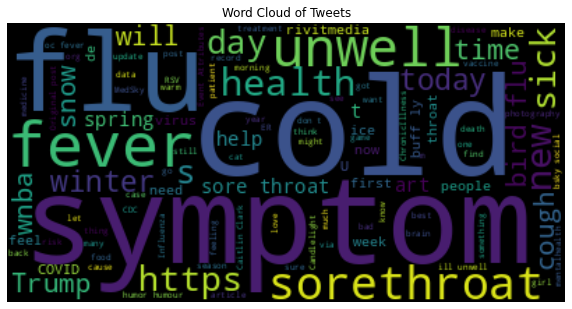

In [19]:
from wordcloud import WordCloud

# Combine all tweets into one large string
all_tweets = " ".join(bluesky_pd['contents'].dropna())

# Create a word cloud
wordcloud = WordCloud().generate(all_tweets)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

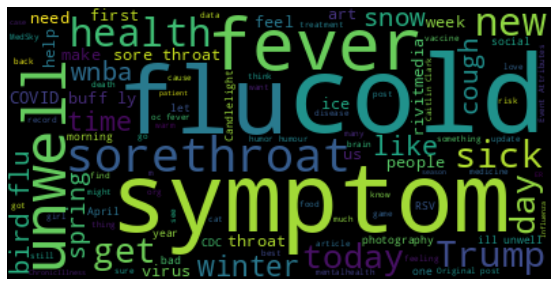

In [20]:
wordcloud = WordCloud(stopwords=stopWords ).generate(all_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

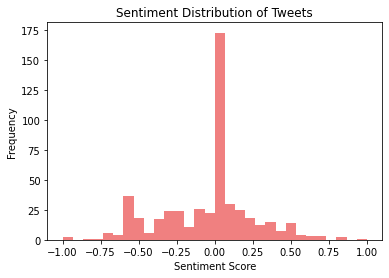

In [21]:
from textblob import TextBlob

# Sentiment polarity (ranging from -1 to 1)
bluesky_pd['sentiment'] = bluesky_pd['contents'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualize the distribution of sentiment
plt.hist(bluesky_pd['sentiment'], bins=30, color='lightcoral')
plt.title('Sentiment Distribution of Tweets')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### Preparing data for modeling (LDA and Clustering)

In [13]:
bluesky_with_length = bluesky_new.withColumn("length", length("contents"))

In [14]:
bluesky_model_cluster = full_pipeline.fit(bluesky_with_length)

bluesky_cleaned_cluster = bluesky_model_cluster.transform(bluesky_with_length)

# Display the data
bluesky_cleaned_cluster.show()

+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|        display_name|            contents|           timestamp|     timestamp_clean|length|    content_filtered|      filtered_words|            features|      final_features|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|🌊👿Nemorra Dusk?...|Hey, Duskies! No ...|2025-04-20T18:49:...|2025-04-20 18:49:...|   228|[hey, duskies, no...|[hey, duskies, st...|(4285,[5,9,12,31,...|(4286,[5,9,12,31,...|
|Clara - Acupunctu...|ST 9, ST 10, & ST...|2025-04-07T16:30:...|2025-04-07 16:30:...|   296|[st, 9, st, 10, s...|[st, 9, st, 10, s...|(4285,[5,9,63,130...|(4286,[5,9,63,130...|
|Omni Medical Serv...|"Smoking cannabis...|2025-04-03T13:54:...|2025-04-03 13:54:...|   265|[smoking, cannabi...|[smo

In [15]:
# creating lda pipeline without vector assembler
lda_pipeline = Pipeline(stages=[
    regex_token,
    stop_words_remover,
    count_vectorizer
])

In [16]:
#preparing the data for lda
bluesky_model_lda = lda_pipeline.fit(bluesky_new)

bluesky_cleaned_lda = bluesky_model_lda.transform(bluesky_new)

# Display the data
bluesky_cleaned_lda.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        display_name|            contents|           timestamp|     timestamp_clean|    content_filtered|      filtered_words|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|🌊👿Nemorra Dusk?...|Hey, Duskies! No ...|2025-04-20T18:49:...|2025-04-20 18:49:...|[hey, duskies, no...|[hey, duskies, st...|(4285,[5,9,12,31,...|
|Clara - Acupunctu...|ST 9, ST 10, & ST...|2025-04-07T16:30:...|2025-04-07 16:30:...|[st, 9, st, 10, s...|[st, 9, st, 10, s...|(4285,[5,9,63,130...|
|Omni Medical Serv...|"Smoking cannabis...|2025-04-03T13:54:...|2025-04-03 13:54:...|[smoking, cannabi...|[smoking, cannabi...|(4285,[5,9,25,140...|
|The Pharmaceutica...|NHS England’s ‘Ac...|2025-04-03T09:17:...|2025-04-03 09:17:...|[nhs, england, s,...|[n

##### Bluesky LDA

In [17]:
from pyspark.ml.clustering import LDA
bluesky_lda = LDA(k = 2, maxIter = 10, seed = 101, featuresCol = "features")

bluesky_ldaModel = bluesky_lda.fit(bluesky_cleaned_lda)

In [35]:
bluesky_ldaModel.save("bluesky_lda_model")

In [18]:
cv_model = bluesky_model_lda.stages[2]

vocab = cv_model.vocabulary

In [36]:
cv_model.save("bluesky_cv_model")

In [19]:
bluesky_ldaModel.describeTopics(maxTermsPerTopic = 10).select('termIndices').collect()[0].asDict()['termIndices']

[0, 2, 1, 4, 6, 10, 7, 5, 3, 36]

In [20]:
topics = bluesky_ldaModel.describeTopics(maxTermsPerTopic = 10)

In [21]:
collected_topics = topics.collect()  # Convert to list

# Check how many topics were actually returned
print(f"Number of topics available: {len(collected_topics)}")

Number of topics available: 2


In [22]:
topics.select('termIndices').collect()

[Row(termIndices=[0, 2, 1, 4, 6, 10, 7, 5, 3, 36]),
 Row(termIndices=[3, 8, 1, 48, 5, 37, 51, 22, 39, 9])]

In [23]:
print(len(vocab))

4285


In [24]:
topics_list = topics.select('termIndices').collect()

# Show the top 10 terms for each topic
for i, row in enumerate(topics_list):
    print(f"Topic {i}: ", end="")
    for idx in row['termIndices']:
        if idx < len(vocab):
            print(vocab[idx], end=' ')
        else:
            print(f"[Invalid index {idx}]", end=' ')
    print()

Topic 0: flu fever cold unwell health sick 2025 sorethroat symptoms best 
Topic 1: symptoms adware cold buff sorethroat ly ice malware rivitmedia throat 


#### Bluesky Clustering

In [25]:
from pyspark.ml.clustering import KMeans

In [26]:
kmeans = KMeans(featuresCol="final_features", predictionCol="cluster", k=3, seed=101)

In [27]:
kmeans_model = kmeans.fit(bluesky_cleaned_cluster)

In [28]:
kmeans_result = kmeans_model.transform(bluesky_cleaned_cluster)

In [29]:
kmeans_result.groupBy("cluster").count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|  155|
|      2|  141|
|      0|  210|
+-------+-----+



#### Examining the silhouette score

In [30]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol='final_features', predictionCol='cluster', metricName='silhouette', distanceMeasure='squaredEuclidean')
score = evaluator.evaluate(kmeans_result)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.7541204727781818


In [31]:
kmeans_result_filtered = kmeans_result.select("display_name", "contents", "timestamp", "filtered_words", "cluster")

In [32]:
kmeans_result_filtered.show()

+--------------------+--------------------+--------------------+--------------------+-------+
|        display_name|            contents|           timestamp|      filtered_words|cluster|
+--------------------+--------------------+--------------------+--------------------+-------+
|🌊👿Nemorra Dusk?...|Hey, Duskies! No ...|2025-04-20T18:49:...|[hey, duskies, st...|      0|
|Clara - Acupunctu...|ST 9, ST 10, & ST...|2025-04-07T16:30:...|[st, 9, st, 10, s...|      0|
|Omni Medical Serv...|"Smoking cannabis...|2025-04-03T13:54:...|[smoking, cannabi...|      0|
|The Pharmaceutica...|NHS England’s ‘Ac...|2025-04-03T09:17:...|[nhs, england, ac...|      0|
|              NKVSSP|nkvssp.thecomicse...|2025-04-01T18:49:...|[nkvssp, thecomic...|      0|
|  NuttyBlueRice Ⓜ️🍚|Peter gets a sore...|2025-03-30T04:15:...|[peter, gets, sor...|      1|
|The Sex Wrap Podcast|#sexinadvertising...|2025-03-25T00:55:...|[sexinadvertising...|      0|
|The Gay Horse Coo...|Wellllll, I think...|2025-03-21T16:49:...

### Enhancing Bluesky Models (LDA and cluster)

##### Improving LDA Model

In [33]:
print("Perplexity: ", bluesky_ldaModel.logPerplexity(bluesky_cleaned_lda)) #measures how well the model generalizes


Perplexity:  8.514822359140602


#### Trying different k values

In [34]:
# trying different values of k to see if the model's generalization fluctuates with more topics
def tune_k(data, k_values):
    best_k = None
    best_perplexity = float('inf')
    
    # Iterate through different k values
    for k in k_values:
        lda = LDA(k=k, maxIter=10)
        lda_model = lda.fit(bluesky_cleaned_lda)
        perplexity = lda_model.logPerplexity(bluesky_cleaned_lda)
        
        print(f"K = {k}, Perplexity = {perplexity}")
        
        # Track the best k
        if perplexity < best_perplexity:
            best_perplexity = perplexity
            best_k = k
    
    return best_k, best_perplexity

#range of k values from 2 to 10
k_values = range(2, 16) 


best_k, best_perplexity = tune_k(bluesky_cleaned_lda, k_values)

print(f"Best K: {best_k} with Perplexity: {best_perplexity}")

K = 2, Perplexity = 8.53206796050576
K = 3, Perplexity = 8.81172499419659
K = 4, Perplexity = 9.175818511995665
K = 5, Perplexity = 9.637042189711241
K = 6, Perplexity = 10.169123216102026
K = 7, Perplexity = 10.75381108771276
K = 8, Perplexity = 11.38940651542094
K = 9, Perplexity = 12.093045877903267
K = 10, Perplexity = 12.823192607815333
K = 11, Perplexity = 13.591979255793039
K = 12, Perplexity = 14.399530584511664
K = 13, Perplexity = 15.248211167436258
K = 14, Perplexity = 16.111931695960752
K = 15, Perplexity = 17.006656068011253
Best K: 2 with Perplexity: 8.53206796050576


##### After evaluating the LDA model using perplexity, we found that k = 2 produced the lowest value (8.532), indicating the best model fit. As the number of topics increased, perplexity also increased, suggesting that the dataset naturally clusters into two main topics and that more topics lead to overfitting.

#### Adding bigrams

In [32]:
# adding bigrams
from pyspark.ml.feature import NGram

# Create bigrams using filtered words
bigram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")


count_vectorizer2 = CountVectorizer(inputCol="bigrams", outputCol="features")

In [33]:
lda_pipeline2 = Pipeline(stages=[
    regex_token,
    stop_words_remover,
    bigram,
    count_vectorizer2
])

In [34]:
bluesky_model_lda2 = lda_pipeline2.fit(bluesky_new)

bluesky_cleaned_lda2 = bluesky_model_lda2.transform(bluesky_new)
bluesky_cleaned_lda2.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        display_name|            contents|           timestamp|     timestamp_clean|    content_filtered|      filtered_words|             bigrams|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|🌊👿Nemorra Dusk?...|Hey, Duskies! No ...|2025-04-20T18:49:...|2025-04-20 18:49:...|[hey, duskies, no...|[hey, duskies, st...|[hey duskies, dus...|(7424,[1074,1220,...|
|Clara - Acupunctu...|ST 9, ST 10, & ST...|2025-04-07T16:30:...|2025-04-07 16:30:...|[st, 9, st, 10, s...|[st, 9, st, 10, s...|[st 9, 9 st, st 1...|(7424,[965,1181,1...|
|Omni Medical Serv...|"Smoking cannabis...|2025-04-03T13:54:...|2025-04-03 13:54:...|[smoking, cannabi...|[smoking, cannabi...|[smoking cannabis...|(742

In [35]:
bluesky_lda2 = LDA(k = 2, maxIter = 10, seed = 101, featuresCol = "features")

bluesky_ldaModel2 = bluesky_lda2.fit(bluesky_cleaned_lda2)

In [36]:
cv_model2 = bluesky_model_lda2.stages[3]

vocab2 = cv_model2.vocabulary

In [37]:
bluesky_ldaModel2.describeTopics(maxTermsPerTopic = 10).select('termIndices').collect()[0].asDict()['termIndices']

[7, 22, 0, 4, 13, 37, 32, 87, 39, 59]

In [38]:
topics2 = bluesky_ldaModel2.describeTopics(maxTermsPerTopic = 10)

In [39]:
collected_topics2 = topics2.collect()  # Convert to list

# Check how many topics were actually returned
print(f"Number of topics available: {len(collected_topics2)}")

Number of topics available: 2


In [40]:
topics2.select('termIndices').collect()

[Row(termIndices=[7, 22, 0, 4, 13, 37, 32, 87, 39, 59]),
 Row(termIndices=[3, 5, 23, 6, 12, 49, 79, 8, 33, 47])]

In [41]:
print(len(vocab2))

7424


In [42]:
# this is et the topic term indices once
topics_list2 = topics2.select('termIndices').collect()

# Show the top 10 terms for each topic
for i, row in enumerate(topics_list2):
    print(f"Topic {i}: ", end="")
    for idx in row['termIndices']:
        if idx < len(vocab2):
            print(vocab2[idx], end=' ')
        else:
            print(f"[Invalid index {idx}]", end=' ')
    print()

Topic 0: original post simulation games bird flu cold flu rivitmedia cyberthreats games ios cdc gov youtube adware ios android flu season 
Topic 1: buff ly ill unwell indiana fever humor humour caitlin clark napheesa collier sick unwell event attributes unwell mischief gallstones ill 


In [43]:
print("Perplexity: ", bluesky_ldaModel2.logPerplexity(bluesky_cleaned_lda2))

Perplexity:  9.650974645983071


#### Improving cluster (Kmeans)

In [44]:
cost = []
k_vals = list(range(2, 11))  # Trying k values from 2 to 10

for k in k_vals:
    kmeans = KMeans(featuresCol="final_features", predictionCol="cluster", k=k, seed=101)
    model = kmeans.fit(bluesky_cleaned_cluster)
    wcss = model.summary.trainingCost  # WCSS / Inertia
    cost.append(wcss)

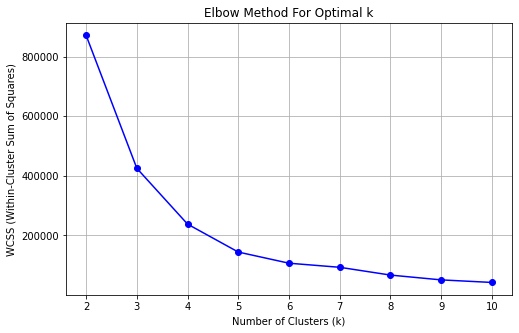

In [47]:
plt.figure(figsize=(8, 5))
plt.plot(k_vals, cost, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

#### Training kmeans using optimal k

In [37]:
optimal_k = 5
kmeans2 = KMeans(featuresCol="final_features", predictionCol="cluster", k=optimal_k, seed=101)
kmeans_model2 = kmeans2.fit(bluesky_cleaned_cluster)
kmeans_result2 = kmeans_model2.transform(bluesky_cleaned_cluster)

In [42]:
optimal_k = 5
kmeans2 = KMeans(featuresCol="final_features", predictionCol="cluster", k=optimal_k, seed=101)
kmeans_model2 = kmeans2.fit(bluesky_cleaned_cluster)
kmeans_result2 = kmeans_model2.transform(bluesky_cleaned_cluster)

In [41]:
kmeans_model2.save("bluesky_kmeans_model")

In [38]:
kmeans_result_filtered2 = kmeans_result2.select("display_name", "contents", "timestamp", "filtered_words", "cluster")

In [39]:
kmeans_result_filtered2.show()

+--------------------+--------------------+--------------------+--------------------+-------+
|        display_name|            contents|           timestamp|      filtered_words|cluster|
+--------------------+--------------------+--------------------+--------------------+-------+
|🌊👿Nemorra Dusk?...|Hey, Duskies! No ...|2025-04-20T18:49:...|[hey, duskies, st...|      2|
|Clara - Acupunctu...|ST 9, ST 10, & ST...|2025-04-07T16:30:...|[st, 9, st, 10, s...|      0|
|Omni Medical Serv...|"Smoking cannabis...|2025-04-03T13:54:...|[smoking, cannabi...|      0|
|The Pharmaceutica...|NHS England’s ‘Ac...|2025-04-03T09:17:...|[nhs, england, ac...|      2|
|              NKVSSP|nkvssp.thecomicse...|2025-04-01T18:49:...|[nkvssp, thecomic...|      0|
|  NuttyBlueRice Ⓜ️🍚|Peter gets a sore...|2025-03-30T04:15:...|[peter, gets, sor...|      4|
|The Sex Wrap Podcast|#sexinadvertising...|2025-03-25T00:55:...|[sexinadvertising...|      2|
|The Gay Horse Coo...|Wellllll, I think...|2025-03-21T16:49:...

In [51]:
kmeans_result2.groupBy("cluster").count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|  106|
|      3|   51|
|      4|  110|
|      2|   91|
|      0|  148|
+-------+-----+



##### To get a sense of what contents are contained in each cluster

In [79]:
#rerun this
kmeans_result2.select("cluster", "contents").groupBy("cluster").agg(F.collect_list("contents")).show(truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Examining the silhouette score

In [40]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol='final_features', predictionCol='cluster', metricName='silhouette', distanceMeasure='squaredEuclidean')
score = evaluator.evaluate(kmeans_result2)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.7520094515141605


We can see that increasing k to 5 sliglthly improved the silhouette score by a little. The silhouette score is a metric to access how well defined the clusters are.